# Sparsity-Constrained ALS Component Augmentation Tests

This notebook has two sections:

1. **ArgR replacement**: remove `Arginine`, add `ArgR` from regulon prior, reoptimize.
2. **Adding Regulon case studies**: add one regulon-based column at a time for `CadC`, `ChbR`, `DecR`, `EnvR`, `EnvY`, then reoptimize.

For every case, the notebook computes colinearity checks against all other components and plots the absolute-correlation histogram (x-axis fixed to 0..1).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
from pathlib import Path
from scipy.linalg import pinv
from pymodulon.core import IcaData
from pymodulon.io import load_json_model
from pymodulon.plotting import *

# -----------------------------
# Font setup: enforce Arial.ttf
# -----------------------------
ARIAL_FONT_PATH = Path('/usr/share/fonts/truetype/msttcorefonts/Arial.ttf')
if not ARIAL_FONT_PATH.exists():
    raise FileNotFoundError(f'Arial font file not found: {ARIAL_FONT_PATH}')

fm.fontManager.addfont(str(ARIAL_FONT_PATH))
arial_name = fm.FontProperties(fname=str(ARIAL_FONT_PATH)).get_name()

mpl.rcParams.update({
    'font.family': arial_name,
    'font.sans-serif': [arial_name],
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'svg.fonttype': 'none',
})

pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 180)

DATA_DIR = Path('Data')
FIG_DIR = Path('Figures')
FIG_DIR.mkdir(parents=True, exist_ok=True)

print('Using font:', arial_name)
print('Figure output directory:', FIG_DIR)


Using font: Arial
Figure output directory: Figures


In [ ]:
# Load data
X_df = pd.read_csv(DATA_DIR / 'P1K_X.csv', index_col=0)
M_df = pd.read_csv(DATA_DIR / 'P1K_M.csv', index_col=0)
A_df = pd.read_csv(DATA_DIR / 'P1K_A.csv', index_col=0)
presence_df = pd.read_csv(DATA_DIR / 'P1K_Gene_Presence_Matrix.csv', index_col=0)
regulon_df = pd.read_csv(DATA_DIR / 'regulon_p1k.csv', index_col=0)
M_robust_df = pd.read_csv(DATA_DIR / 'M_robust_iterative.csv', index_col=0)

# Align to full P1K decomposition gene space (4257 genes)
# Keep genes shared by X, M, and presence only; do NOT shrink by regulon coverage.
base_genes = [g for g in X_df.index if g in M_df.index and g in presence_df.index]
base_components = [c for c in M_df.columns if c in A_df.index and c in presence_df.columns]

X_base = X_df.loc[base_genes]
M_base = M_df.loc[base_genes, base_components]
A_base = A_df.loc[base_components, X_base.columns]
presence_base = presence_df.loc[base_genes, base_components].astype(bool)

# Regulon table has 3189 genes; reindex to 4257-gene space and fill missing genes with 0.
regulon_base = regulon_df.reindex(base_genes).fillna(0)
M_robust_base = M_robust_df.reindex(base_genes).fillna(0.0)

print('Aligned shapes:')
print('X_base:', X_base.shape)
print('M_base:', M_base.shape)
print('A_base:', A_base.shape)
print('presence_base:', presence_base.shape)
print('regulon_base:', regulon_base.shape)
print('M_robust_base:', M_robust_base.shape)
print('Genes missing in regulon, filled as 0:', int((~pd.Index(base_genes).isin(regulon_df.index)).sum()))

In [3]:
precise1k = load_json_model('./Data/p1k.json.gz')

In [4]:
def plot_gene_weights(ica_data, imodulon, by="start", xaxis=None, xname="", save_as=None, **kwargs):
    """
    Plot gene weights on a scatter plot.

    Parameters
    ----------
    ica_data: ~pymodulon.core.IcaData
        :class:`~pymodulon.core.IcaData` object
    imodulon : int or str
        `iModulon` name
    by: 'log-tpm-norm', 'length', or 'start'
        Property to plot on x-axis. Superceded by `xaxis`
    xaxis: list, dict or ~pandas.Series, optional
        Values on custom x-axis
    xname: str, optional
        Name of x-axis if using custom x-axis
    save_as: str, optional
        File name to save the plot as SVG
    **kwargs:
        Additional keyword arguments passed to :func:`pymodulon.plotting.scatterplot`
    Returns
    -------
    ax: ~matplotlib.axes.Axes
        :class:`~matplotlib.axes.Axes` containing the scatterplot
    """
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Arial.ttf'
    font_prop = fm.FontProperties(fname=font_path)

    # Check that iModulon exists
    if imodulon in ica_data.M.columns:
        y = ica_data.M[imodulon]
        ylabel = f"{imodulon} Gene Weight"
    else:
        raise ValueError(f"iModulon does not exist: {imodulon}")

    # Get genes in the iModulon
    bin_M = ica_data.M_binarized
    component_genes = set(bin_M[imodulon].loc[bin_M[imodulon] == 1].index)
    other_genes = set(bin_M[imodulon].loc[bin_M[imodulon] == 0].index)

    # If experimental `xaxis` parameter is used, use custom values for x-axis
    if xaxis is not None:
        x = _set_xaxis(xaxis=xaxis, y=y)
        xlabel = xname

    else:
        # Ensure 'by' has a valid input and assign x, xlabel accordingly
        if by == "log-tpm":
            x = ica_data.log_tpm.mean(axis=1)
            xlabel = "Mean Expression"
        elif by == "log-tpm-norm":
            x = ica_data.X.mean(axis=1)
            xlabel = "Mean Centered Expression"
        elif by == "length":
            x = np.log10(ica_data.gene_table.length)
            xlabel = "Gene Length (log10-scale)"
        elif by == "start":
            x = ica_data.gene_table.start
            xlabel = "Gene Start (1e6)"
        else:
            raise ValueError(
                '"by" must be "log-tpm", "log-tpm-norm", "length", or "start"'
            )

    # Override specific kwargs (their implementation is different in this function)
    show_labels_pgw = kwargs.pop("show_labels", "auto")
    adjust_labels_pgw = kwargs.pop("adjust_labels", True)
    legend_kwargs_pgw = kwargs.pop("legend_kwargs", {})
    label_font_kwargs_pgw = kwargs.pop("label_font_kwargs", {})

    kwargs["show_labels"] = kwargs["adjust_labels"] = False

    # Remove xlabel and ylabel kwargs if provided
    kwargs.pop("xlabel", None)
    kwargs.pop("ylabel", None)

    # Default legend should be on the side of the plot
    if (
        "bbox_to_anchor" not in legend_kwargs_pgw.keys()
        and "loc" not in legend_kwargs_pgw.keys()
    ):
        legend_kwargs_pgw.update({"bbox_to_anchor": (1, 1), "loc": 2})
        kwargs["legend_kwargs"] = legend_kwargs_pgw

    # Update colors for COG groups
    if "COG" in ica_data.gene_table.columns and "groups" not in kwargs:
        mod_cogs = ica_data.gene_table.loc[component_genes].COG
        hidden_cogs = pd.Series("hidden", index=other_genes)
        all_cogs = pd.concat([mod_cogs, hidden_cogs])
        kwargs.update({"groups": all_cogs, "colors": ica_data.cog_colors})

    # Scatter Plot
    ax = scatterplot(x, y, xlabel=xlabel, ylabel=ylabel, **kwargs)

    # Remove grid
    ax.grid(False)

    # Add black box around the plot
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

    # Add thresholds to scatter-plot (dashed lines)
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    thresh = ica_data.thresholds[imodulon]
    if thresh != 0:
        ax.hlines(
            [thresh, -thresh],
            xmin=xmin,
            xmax=xmax,
            colors="k",
            linestyles="dashed",
            linewidth=1,
        )

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    texts = []
    expand_kwargs = {"expand_objects": (1.2, 1.4), "expand_points": (1.3, 1.3)}

    # Add labels: Put gene name if components contain under 20 genes
    if show_labels_pgw is True or (
        show_labels_pgw is not False and len(component_genes) <= 20
    ):
        for gene in component_genes:
            # Add labels
            text_kwargs = label_font_kwargs_pgw.copy()

            if "fontstyle" not in text_kwargs:
                text_kwargs.update({"fontstyle": "normal"})

            # Italicize gene if there is a defined name (not locus tag)
            try:
                gene_name = ica_data.gene_table.loc[gene, "gene_name"]

                if gene_name != gene:
                    text_kwargs.update({"fontstyle": "italic"})

            except KeyError:
                gene_name = gene

            # Set default fontsize
            if "fontsize" not in text_kwargs:
                text_kwargs.update({"fontsize": 12})

            texts.append(
                ax.text(
                    x[gene],
                    ica_data.M.loc[gene, imodulon],
                    gene_name,
                    fontproperties=font_prop,
                    **text_kwargs,
                )
            )

        expand_kwargs["expand_text"] = (1.4, 1.4)

    # Add labels: Repel texts from other text and points
    rect = ax.add_patch(
        Rectangle(
            xy=(xmin, -abs(thresh)),
            width=xmax - xmin,
            height=2 * abs(thresh),
            fill=False,
            linewidth=0,
        )
    )

    if adjust_labels_pgw:
        adjust_text(
            texts=texts,
            add_objects=[rect],
            ax=ax,
            arrowprops=dict(arrowstyle="-", color="k", lw=0.5),
            only_move={"objects": "y"},
            **expand_kwargs,
        )

    # Save plot to SVG format if save_as is provided
    if save_as:
        plt.savefig(save_as, format='svg')

    return ax

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from adjustText import adjust_text
from matplotlib.ticker import FuncFormatter  # Import FuncFormatter

def scatterplot(
    x,
    y,
    groups=None,
    colors=None,
    show_labels="auto",
    adjust_labels=True,
    line45=False,
    line45_margin=0,
    fit_line=False,
    fit_metric="pearson",
    xlabel="",
    ylabel="",
    ax=None,
    legend=True,
    ax_font_kwargs=None,
    scatter_kwargs=None,
    label_font_kwargs=None,
    legend_kwargs=None,
):

    # Path to your custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Arial.ttf'
    font_prop = fm.FontProperties(fname=font_path)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 4.5))

    if show_labels == "auto":
        show_labels = len(x) <= 20

    if not (
        isinstance(x, pd.Series)
        and isinstance(y, pd.Series)
        and (
            x.index.astype(str).sort_values() == y.index.astype(str).sort_values()
        ).all()
    ):
        raise TypeError("X and Y must be pandas series with the same index")

    # Set up data object
    data = pd.DataFrame({"x": x, "y": y})

    # Add group information
    data["group"] = ""
    if groups is not None:
        for k, val in groups.items():
            data.loc[k, "group"] = val

    # Handle custom kwargs
    if ax_font_kwargs is None:
        ax_font_kwargs = {}

    if label_font_kwargs is None:
        label_font_kwargs = {}

    if legend_kwargs is None:
        legend_kwargs = {}

    if scatter_kwargs is None:
        scatter_kwargs = {}

    # Get x and y limits
    margin = 0.1
    xrange = x.max() - x.min()
    yrange = y.max() - y.min()
    xmin = x.min() - xrange * margin
    xmax = x.max() + xrange * margin
    ymin = y.min() - yrange * margin
    ymax = y.max() + yrange * margin
    allmin = max(xmin, ymin)
    allmax = min(xmax, ymax)

    # Add 45 degree line
    if line45:
        # Plot diagonal lines
        ax.plot(
            [allmin, allmax],
            [allmin, allmax],
            color="k",
            linestyle="dashed",
            linewidth=0.5,
            zorder=0,
        )

        if line45_margin > 0:
            diff = pd.DataFrame(abs(data.x - data.y), index=data.index)
            hidden = diff.loc[diff[0] < line45_margin]
            data.loc[hidden.index, "group"] = "hidden"
            ax.plot(
                [max(xmin, ymin + line45_margin), min(xmax, ymax + line45_margin)],
                [max(ymin, xmin - line45_margin), min(ymax, xmax - line45_margin)],
                color="gray",
                linestyle="dashed",
                linewidth=0.5,
                zorder=0,
            )
            ax.plot(
                [max(xmin, ymin - line45_margin), min(xmax, ymax - line45_margin)],
                [max(ymin, xmin + line45_margin), min(ymax, xmax + line45_margin)],
                color="gray",
                linestyle="dashed",
                linewidth=0.5,
                zorder=0,
            )

    # Add colors to the data
    # If colors is already a dict, just update the hidden color
    try:
        if "hidden" not in colors.keys():
            colors.update({"hidden": "gray"})
        if "" not in colors.keys():
            colors.update({"": "tab:blue"})
    except AttributeError:

        groups = [item for item in data["group"].unique() if item != "hidden"]
        if colors is None:
            colorlist = plt.rcParams["axes.prop_cycle"].by_key()["color"]
        elif isinstance(colors, str):
            colorlist = [colors] * len(groups)
        else:
            colorlist = list(colors)

        # Deal with short colorlists
        if len(colorlist) < len(groups):
            colorlist = colorlist * (len(groups) // len(colorlist) + 1)

        colors = dict(zip(groups, colorlist))
        colors.update({"hidden": "gray"})

    # for name, group in data.groupby("group"):
    #     kwargs = scatter_kwargs.copy()
    #     kwargs["color"] = colors[name]
    #     # Override defaults for hidden points
    #     if name == "hidden":
    #         kwargs.update({"alpha": 0.7, "linewidth": 0, "label": None})
    #     elif name == "":
    #         kwargs.update({"label": None})
    #     else:
    #         kwargs.update({"label": name})

    #     ax.scatter(group.x, group.y, **kwargs, zorder=1)
    for name, group in data.groupby("group"):
        kwargs = scatter_kwargs.copy()
        kwargs["color"] = colors[name]
    
        if name == "hidden":
            kwargs.update({"alpha": 0.7, "linewidth": 0, "label": None})
            pc = ax.scatter(group.x, group.y, **kwargs, zorder=1)
            pc.set_rasterized(True)          # <--- key line
            # optional: make sure it's actually rasterized on save
            # pc.set_zorder(0)  # if you want it behind other points
        else:
            if name == "":
                kwargs.update({"label": None})
            else:
                kwargs.update({"label": name})
            ax.scatter(group.x, group.y, **kwargs, zorder=1)

    # Add regression
    if fit_line:
        _fit_line(x, y, ax, fit_metric)

    # Add lines at 0
    if xmin < 0 < xmax:
        ax.hlines(0, xmin, xmax, linewidth=0.5, color="gray", zorder=2)
    if ymin < 0 < ymax:
        ax.vlines(0, ymin, ymax, linewidth=0.5, color="gray", zorder=2)

    # Add labels
    if show_labels:
        texts = []
        for idx in x.index:
            texts.append(ax.text(x[idx], y[idx], idx, fontproperties=font_prop, **label_font_kwargs))
        if adjust_labels:
            adjust_text(
                texts,
                ax=ax,
                arrowprops=dict(arrowstyle="-", color="k", lw=0.5),
                only_move={"objects": "y"},
                expand_objects=(1.2, 1.4),
                expand_points=(1.3, 1.3),
            )

    if np.allclose(xmin, xmax):
        ax.set_xlim(xmin - 1, xmax + 1)
    else:
        ax.set_xlim(xmin, xmax)

    if np.allclose(ymin, ymax):
        ax.set_ylim(ymin - 1, ymax + 1)
    else:
        ax.set_ylim(ymin, ymax)

    ax.set_xlabel(xlabel, fontproperties=font_prop, **ax_font_kwargs)
    ax.set_ylabel(ylabel, fontproperties=font_prop, **ax_font_kwargs)

    if legend or fit_line:
        legend = ax.legend(**legend_kwargs)
        for text in legend.get_texts():
            text.set_font_properties(font_prop)
            
    # Apply font to tick labels
    for tick in ax.get_xticklabels():
        tick.set_font_properties(font_prop)
    for tick in ax.get_yticklabels():
        tick.set_font_properties(font_prop)
        
    # Ensure y-ticks have two decimal places
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))

    return ax


In [3]:
# constrained ALS
def constrained_als_optimize(X_df, M_seed_df, mask_df, n_iter=40, tol=1e-7, verbose=False):
    X = X_df.to_numpy(float)
    M = M_seed_df.to_numpy(float).copy()
    mask = mask_df.astype(float).to_numpy(float)

    prev_error = np.inf
    history = []

    for i in range(n_iter):
        A = pinv(M) @ X
        M_new = X @ pinv(A)
        M_new = M_new * mask

        col_norms = np.linalg.norm(M_new, axis=0)
        col_norms[col_norms == 0] = 1.0
        M = M_new / col_norms

        A = pinv(M) @ X
        error = np.linalg.norm(X - M @ A, ord='fro')
        history.append(error)

        if verbose:
            print(f'iter {i:03d} | error={error:.6f}')

        if abs(prev_error - error) < tol:
            if verbose:
                print(f'Converged at iteration {i}')
            break
        prev_error = error

    M_out = pd.DataFrame(M, index=M_seed_df.index, columns=M_seed_df.columns)
    A_out = pd.DataFrame(A, index=M_seed_df.columns, columns=X_df.columns)
    return M_out, A_out, history


def make_scatter_original_vs_new(original_values, new_values, categories, title, save_path='xx.svg'):
    color_map = {
        'Only in P1K iM': '#1f77b4',
        'Only in Regulon': '#ff7f0e',
        'In Both': '#2ca02c',
    }

    mask = categories != 'Neither'
    x = original_values.loc[mask].to_numpy(float)
    y = new_values.loc[mask].to_numpy(float)
    c = categories.loc[mask]

    all_vals = np.concatenate([x, y])
    vmin, vmax = np.min(all_vals), np.max(all_vals)
    pad = 0.05 * (vmax - vmin) if vmax > vmin else 1.0
    lo, hi = vmin - pad, vmax + pad

    fig, ax = plt.subplots(figsize=(6, 6))

    for cat in ['Only in P1K iM', 'Only in Regulon', 'In Both']:
        sel = c == cat
        if sel.any():
            ax.scatter(
                x[sel], y[sel], s=20, alpha=0.8, edgecolors='none',
                color=color_map[cat], label=f'{cat} (n={int(sel.sum())})'
            )

    ax.plot([lo, hi], [lo, hi], linestyle=':', color='black', linewidth=1.5)
    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(False)
    ax.set_xlabel('Original component values')
    ax.set_ylabel('(SC-ALS) Reoptimized component values')
    ax.set_title(title)
    ax.legend(frameon=False)
    plt.tight_layout()

    if save_path is not None:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, format='svg', bbox_inches='tight')
        print('Saved scatter:', save_path)

    plt.show()


def component_abs_correlations(M_df, new_component):
    target = M_df[new_component].to_numpy(float)
    target_std = np.std(target)

    corrs = {}
    for col in M_df.columns:
        if col == new_component:
            continue
        other = M_df[col].to_numpy(float)
        other_std = np.std(other)
        if target_std == 0 or other_std == 0:
            corr = 0.0
        else:
            corr = np.corrcoef(target, other)[0, 1]
            if not np.isfinite(corr):
                corr = 0.0
        corrs[col] = abs(float(corr))

    return pd.Series(corrs, name='abs_correlation').sort_values(ascending=False)


def plot_correlation_hist(corr_series, title, save_path='xx.svg'):
    vals = corr_series.to_numpy(float)
    vals = vals[np.isfinite(vals)]

    fig, ax = plt.subplots(figsize=(8, 1.5))
    bins = np.linspace(0.0, 1.0, 26)
    ax.hist(vals, bins=bins, color='#4c72b0', edgecolor='white', linewidth=0.8)
    ax.set_xlim(-0.05, 1.05)
    ax.grid(False)
    ax.set_xlabel('Absolute correlation with new component')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    plt.tight_layout()

    if save_path is not None:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, format='svg', bbox_inches='tight')
        print('Saved histogram:', save_path)

    plt.show()


def run_case_with_added_component(
    component_name,
    component_values,
    component_mask,
    X_df,
    M_reference,
    A_reference,
    presence_reference,
    n_iter=40,
    tol=1e-7,
    verbose=False,
):
    # Start from reference M/A/presence each time (independent case)
    M_seed = M_reference.copy()
    A_seed = A_reference.copy()
    mask_df = presence_reference.copy()

    # Replace existing component if duplicated name
    if component_name in M_seed.columns:
        M_seed = M_seed.drop(columns=[component_name])
        mask_df = mask_df.drop(columns=[component_name], errors='ignore')
    if component_name in A_seed.index:
        A_seed = A_seed.drop(index=[component_name], errors='ignore')

    M_seed[component_name] = pd.Series(component_values, index=M_seed.index).astype(float)
    A_seed.loc[component_name] = 0.0
    mask_df[component_name] = pd.Series(component_mask, index=mask_df.index).astype(bool)

    # Enforce consistent component ordering
    A_seed = A_seed.loc[M_seed.columns, X_df.columns]
    mask_df = mask_df.loc[M_seed.index, M_seed.columns]

    M_opt, A_opt, history = constrained_als_optimize(X_df, M_seed, mask_df, n_iter=n_iter, tol=tol, verbose=verbose)
    final_error = np.linalg.norm(X_df.to_numpy(float) - M_opt.to_numpy(float) @ A_opt.to_numpy(float), ord='fro')

    return M_opt, A_opt, history, final_error


def plot_retained_imodulon_before_after(
    M_before,
    M_after,
    presence_matrix,
    imodulon='RpoS',
    title='Retained iModulon: Before vs After ALS',
    save_path='xx.svg',
):
    if imodulon not in M_before.columns:
        raise KeyError(f"{imodulon} is not in M_before columns")
    if imodulon not in M_after.columns:
        raise KeyError(f"{imodulon} is not in M_after columns")
    if imodulon not in presence_matrix.columns:
        raise KeyError(f"{imodulon} is not in presence matrix columns")

    common_idx = M_before.index.intersection(M_after.index).intersection(presence_matrix.index)
    gene_mask = presence_matrix.loc[common_idx, imodulon].astype(bool)

    x = M_before.loc[common_idx, imodulon].loc[gene_mask].to_numpy(float)
    y = M_after.loc[common_idx, imodulon].loc[gene_mask].to_numpy(float)

    all_vals = np.concatenate([x, y]) if len(x) > 0 else np.array([0.0, 1.0])
    vmin, vmax = np.min(all_vals), np.max(all_vals)
    pad = 0.05 * (vmax - vmin) if vmax > vmin else 1.0
    lo, hi = vmin - pad, vmax + pad

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.scatter(
        x, y, s=20, alpha=0.85, edgecolors='none',
        color='#1f77b4',
        label=f'iModulon genes (n={len(x)})',
    )

    ax.plot([lo, hi], [lo, hi], linestyle=':', color='black', linewidth=1.5)
    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(False)
    ax.set_xlabel(f'Original {imodulon} M values')
    ax.set_ylabel(f'constrained ALS Re-optimized {imodulon} M values')
    ax.set_title(title)
    ax.legend(frameon=False)
    plt.tight_layout()

    if save_path is not None:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, format='svg', bbox_inches='tight')
        print('Saved retained iModulon scatter:', save_path)

    plt.show()


In [4]:
FIGURES_DIR = Path('Figures')
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

def make_ica_with_precise1k_metadata(M_mat, A_mat, template_ica):
    ica_data = IcaData(M_mat, A_mat)
    ica_data.X = template_ica.X
    ica_data.gene_table = template_ica.gene_table
    ica_data.trn = template_ica.trn
    ica_data.gene_table = template_ica.gene_table
    ica_data.cog_colors = template_ica.cog_colors
    ica_data.sample_table = template_ica.sample_table
    return ica_data

print('Gene-weight plots will be saved to:', FIGURES_DIR)

Gene-weight plots will be saved to: Figures


## Section 1: ArgR Replacement (Remove Arginine, Add ArgR)

In [49]:
# Remove Arginine then add ArgR from regulon prior
if 'ArgR' not in regulon_base.columns:
    raise KeyError('ArgR is not present in regulon_p1k.csv columns')

original_arginine = M_base['Arginine'].copy()
arg_presence = presence_base['Arginine'].astype(bool)
argr_regulon = regulon_base['ArgR'].astype(int).astype(bool)

M_seed_arg = M_base.drop(columns=['Arginine']).copy()
A_seed_arg = A_base.drop(index=['Arginine']).copy()
mask_arg = presence_base.drop(columns=['Arginine']).copy()

M_ArgR, A_ArgR, hist_arg, err_arg = run_case_with_added_component(
    component_name='ArgR',
    component_values=argr_regulon.astype(float),
    component_mask=argr_regulon,
    X_df=X_base,
    M_reference=M_seed_arg,
    A_reference=A_seed_arg,
    presence_reference=mask_arg,
    n_iter=40,
    tol=1e-7,
    verbose=False,
)

print('Section 1 complete: ArgR case')
print('M_ArgR shape:', M_ArgR.shape)
print('A_ArgR shape:', A_ArgR.shape)
print(f'Final reconstruction error: {err_arg:.6f}')

# Colinearity check for new component
corr_ArgR = component_abs_correlations(M_ArgR, 'ArgR')
print('Top 10 absolute correlations for ArgR:')
print(corr_ArgR.head(10))


Section 1 complete: ArgR case
M_ArgR shape: (4257, 201)
A_ArgR shape: (201, 1035)
Final reconstruction error: 1784.939481
Top 10 absolute correlations for ArgR:
Pyrimidine    0.068104
NtrC-1        0.067625
Lrp           0.018927
Cellulose     0.018081
OxyR          0.017653
UC-7          0.016432
RpoS          0.012975
Glutamine     0.010148
Nitrogen      0.009116
Membrane      0.009056
Name: abs_correlation, dtype: float64


ArgR category counts:
Only in Regulon    41
In Both            20
Only in P1K iM      4
dtype: int64
Saved scatter: Figures/section1_argR_scatter.svg


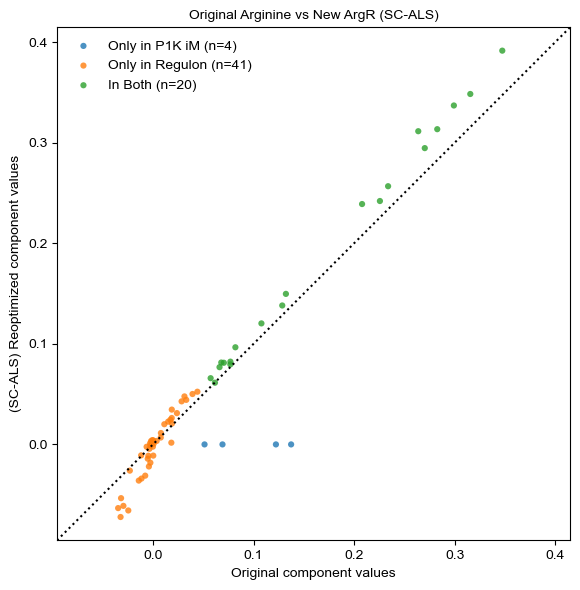

Saved histogram: Figures/section1_argR_correlation_hist.svg


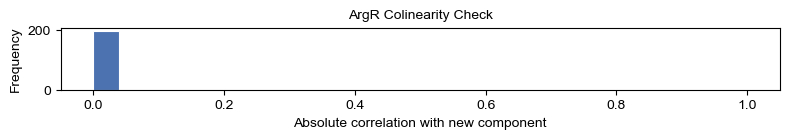

Saved retained iModulon scatter: Figures/section1_RpoS_retained_scatter.svg


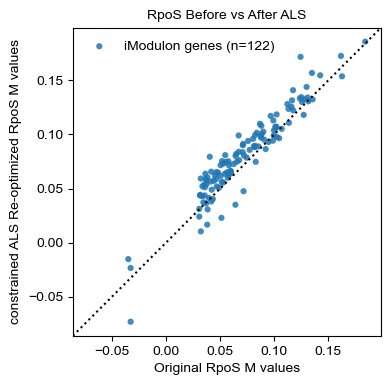

In [50]:
section1_retained_imodulon = 'RpoS'

# Scatter categories for ArgR case
categories_ArgR = pd.Series('Neither', index=M_ArgR.index, dtype=object)
categories_ArgR.loc[arg_presence & ~argr_regulon] = 'Only in P1K iM'
categories_ArgR.loc[~arg_presence & argr_regulon] = 'Only in Regulon'
categories_ArgR.loc[arg_presence & argr_regulon] = 'In Both'

print('ArgR category counts:')
print(categories_ArgR[categories_ArgR != 'Neither'].value_counts())

make_scatter_original_vs_new(
    original_values=original_arginine,
    new_values=M_ArgR['ArgR'],
    categories=categories_ArgR,
    title='Original Arginine vs New ArgR (SC-ALS)',
    save_path=FIG_DIR / 'section1_argR_scatter.svg',
)

plot_correlation_hist(
    corr_series=corr_ArgR,
    title='ArgR Colinearity Check',
    save_path=FIG_DIR / 'section1_argR_correlation_hist.svg',
)


plot_retained_imodulon_before_after(
    M_before=M_base,
    M_after=M_ArgR,
    presence_matrix=presence_base,
    imodulon=section1_retained_imodulon,
    title='RpoS Before vs After ALS',
    save_path=FIG_DIR / 'section1_RpoS_retained_scatter.svg',
)

### Section 2 Manual Gene Weight Plot

In [39]:
ica_data_section2 = make_ica_with_precise1k_metadata(M_ArgR, A_ArgR, precise1k)

Saved: Figures/section2_ArgR_constrained_ALS.svg


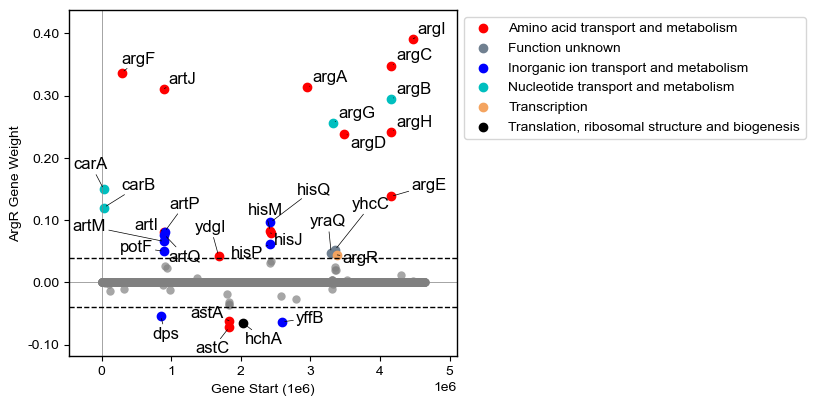

In [40]:
# Customize this component per your need
section2_plot_component = 'ArgR'
section2_plot_path = FIGURES_DIR / f'section2_{section2_plot_component}_constrained_ALS.svg'

ica_data_section2.change_threshold(section2_plot_component, 0.04)

plot_gene_weights(
    ica_data_section2,
    section2_plot_component,
    save_as=str(section2_plot_path),
    show_labels=True,
    adjust_labels=True,
)
print('Saved:', section2_plot_path)

<AxesSubplot:xlabel='Gene Start (1e6)', ylabel='Arginine Gene Weight'>

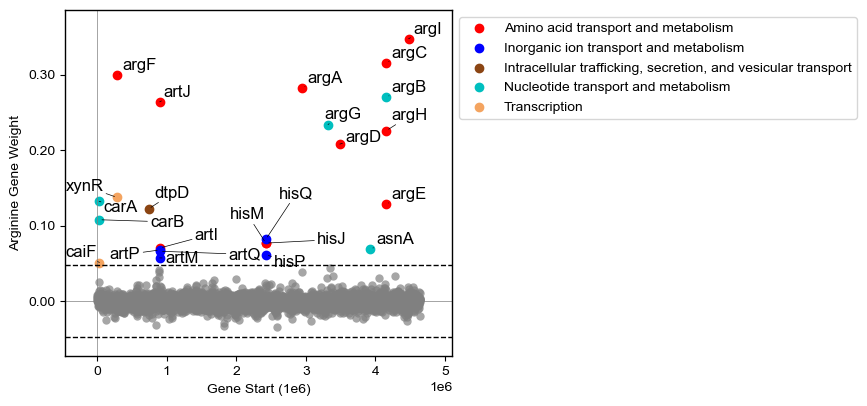

In [41]:
section2_plot_path = FIGURES_DIR / f'section2_arginine_constrained_ALS.svg'
plot_gene_weights(
    precise1k,
    'Arginine',
    save_as=str(section2_plot_path),
    show_labels=True,
    adjust_labels=True,
)

## Section 3: Regulon Case Studies (CadC, ChbR, DecR, EnvR, EnvY)

Case CadC complete | error=1784.239429 | vars: M_CadC, A_CadC
Top 5 abs correlations:
Thr/Ser-1       0.516316
Thr/Ser-2       0.014126
RpoS            0.003355
minicoli KOs    0.003081
PAL 10 Del      0.003064
Name: abs_correlation, dtype: float64
Saved histogram: Figures/section3_CadC_correlation_hist.svg


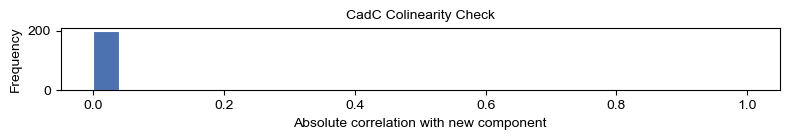

Saved retained iModulon scatter: Figures/section3_CadC_RpoS_retained_scatter.svg


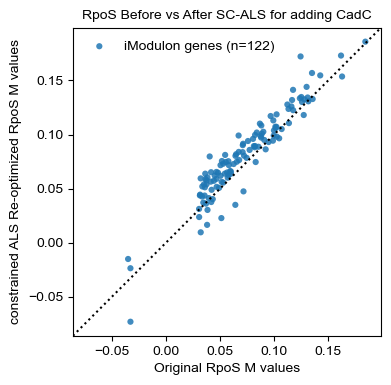

Case ChbR complete | error=1784.151734 | vars: M_ChbR, A_ChbR
Top 5 abs correlations:
GlcNAc          0.050697
pts ALE         0.033817
RpoS            0.005551
minicoli KOs    0.005107
Cellulose       0.005081
Name: abs_correlation, dtype: float64
Saved histogram: Figures/section3_ChbR_correlation_hist.svg


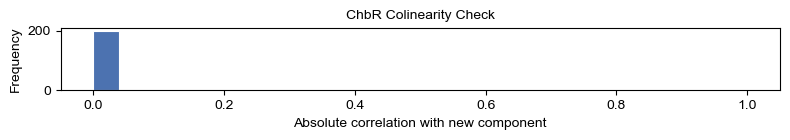

Saved retained iModulon scatter: Figures/section3_ChbR_RpoS_retained_scatter.svg


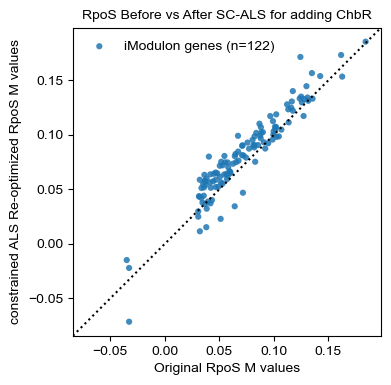

Case DecR complete | error=1784.560532 | vars: M_DecR, A_DecR
Top 5 abs correlations:
RpoS            0.003308
minicoli KOs    0.003036
Cellulose       0.003029
PAL 10 Del      0.003024
PAL Amp         0.002888
Name: abs_correlation, dtype: float64
Saved histogram: Figures/section3_DecR_correlation_hist.svg


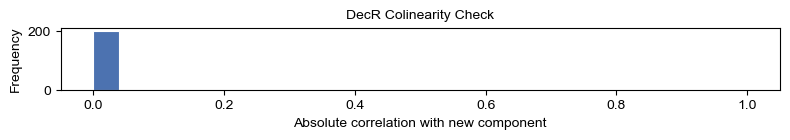

Saved retained iModulon scatter: Figures/section3_DecR_RpoS_retained_scatter.svg


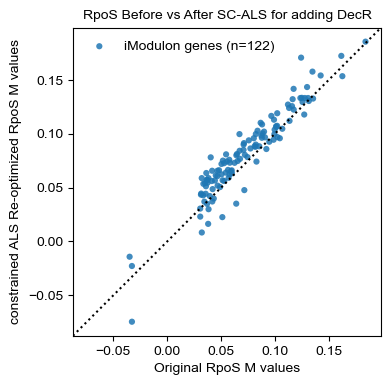

Case EnvR complete | error=1784.505588 | vars: M_EnvR, A_EnvR
Top 5 abs correlations:
SoxS            0.095372
RpoS            0.003312
minicoli KOs    0.003043
Cellulose       0.003030
PAL 10 Del      0.003026
Name: abs_correlation, dtype: float64
Saved histogram: Figures/section3_EnvR_correlation_hist.svg


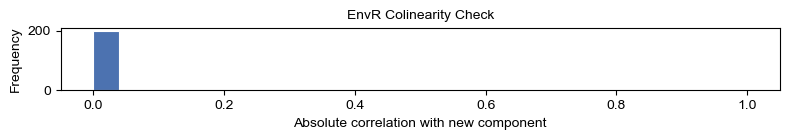

Saved retained iModulon scatter: Figures/section3_EnvR_RpoS_retained_scatter.svg


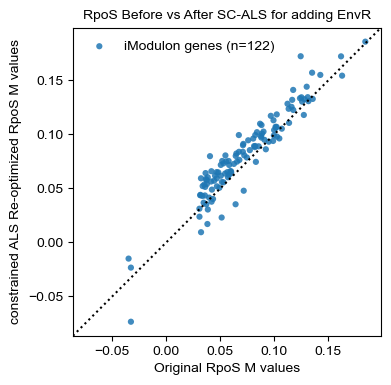

Case EnvY complete | error=1783.997572 | vars: M_EnvY, A_EnvY
Top 5 abs correlations:
Lrp         0.121620
UC-3        0.118791
SoxS        0.054419
Nitrogen    0.053560
RpoS        0.003334
Name: abs_correlation, dtype: float64
Saved histogram: Figures/section3_EnvY_correlation_hist.svg


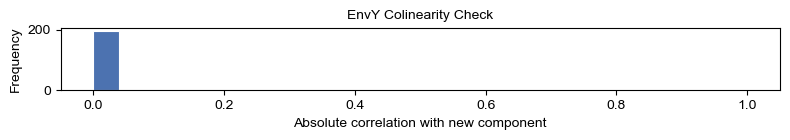

Saved retained iModulon scatter: Figures/section3_EnvY_RpoS_retained_scatter.svg


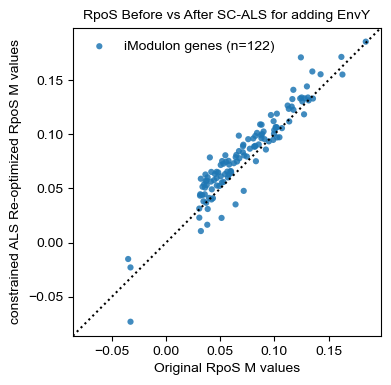

In [51]:
section3_retained_imodulon = 'RpoS'

regulators = ['CadC', 'ChbR', 'DecR', 'EnvR', 'EnvY']
section3_results = {}

for regulator in regulators:
    if regulator not in regulon_base.columns:
        raise KeyError(f'{regulator} not found in regulon_p1k.csv')

    reg_vec = regulon_base[regulator].astype(int).astype(bool)

    M_opt, A_opt, hist, err = run_case_with_added_component(
        component_name=regulator,
        component_values=reg_vec.astype(float),
        component_mask=reg_vec,
        X_df=X_base,
        M_reference=M_base,
        A_reference=A_base,
        presence_reference=presence_base,
        n_iter=40,
        tol=1e-7,
        verbose=False,
    )

    # Store variables requested for later use
    globals()[f'M_{regulator}'] = M_opt
    globals()[f'A_{regulator}'] = A_opt

    corr = component_abs_correlations(M_opt, regulator)
    section3_results[regulator] = {
        'M': M_opt,
        'A': A_opt,
        'history': hist,
        'error': err,
        'corr': corr,
    }

    print(f'Case {regulator} complete | error={err:.6f} | vars: M_{regulator}, A_{regulator}')
    print('Top 5 abs correlations:')
    print(corr.head(5))

    plot_correlation_hist(
        corr_series=corr,
        title=f'{regulator} Colinearity Check',
        save_path=FIG_DIR / f'section3_{regulator}_correlation_hist.svg',
    )

    plot_retained_imodulon_before_after(
        M_before=M_base,
        M_after=M_opt,
        presence_matrix=presence_base,
        imodulon=section3_retained_imodulon,
        title=f'{section3_retained_imodulon} Before vs After SC-ALS for adding {regulator}',
        save_path=FIG_DIR / f'section3_{regulator}_RpoS_retained_scatter.svg',
    )


### Section 3 Manual Gene Weight Plots (One-by-One)

Saved: Figures/section3_ChbR_ChbR_constrained_ALS.svg


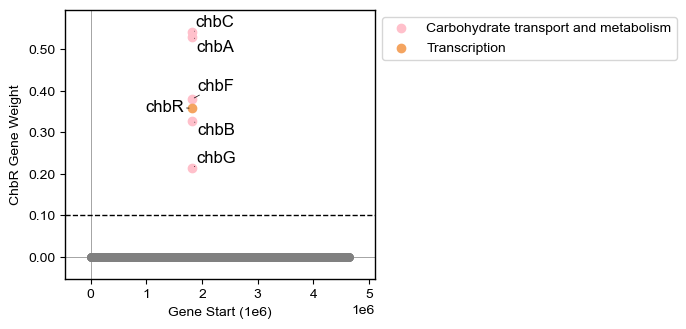

In [15]:
# ChbR (manual)
section3_chbr_plot_component = 'ChbR'
section3_chbr_plot_path = FIGURES_DIR / f'section3_ChbR_{section3_chbr_plot_component}_constrained_ALS.svg'

ica_data_ChbR = make_ica_with_precise1k_metadata(M_ChbR, A_ChbR, precise1k)

ica_data_ChbR.change_threshold(section3_chbr_plot_component, 0.1)

plot_gene_weights(ica_data_ChbR, section3_chbr_plot_component, save_as=str(section3_chbr_plot_path), show_labels=True, adjust_labels=True)
print('Saved:', section3_chbr_plot_path)


Saved: Figures/section3_DecR_DecR_constrained_ALS.svg


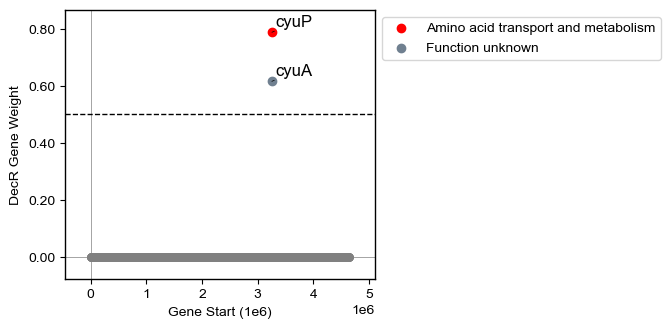

In [18]:
# DecR (manual)
section3_decr_plot_component = 'DecR'
section3_decr_plot_path = FIGURES_DIR / f'section3_DecR_{section3_decr_plot_component}_constrained_ALS.svg'

ica_data_DecR = make_ica_with_precise1k_metadata(M_DecR, A_DecR, precise1k)
ica_data_DecR.change_threshold(section3_decr_plot_component, 0.5)
plot_gene_weights(ica_data_DecR, section3_decr_plot_component, save_as=str(section3_decr_plot_path), show_labels=True, adjust_labels=True)


print('Saved:', section3_decr_plot_path)